In [26]:
import pandas as pd
import os

df = pd.read_csv('./fit.dat', skiprows = 1, sep = ' ',index_col=False, header = None, names = ["iteration", "evaluation", "sigma", "axis ratio", "bestever", "best", "median", "worst objective function value", "further objective values of best", "X"])
row_num = df.shape[0]
dict1 = {"dim": row_num*[1],
        "func": row_num*[2],
        "method": row_num*[3],
        "rep_num": row_num*[4],
        "eval_num": df["evaluation"],
        "bestever": df["bestever"]}
pd.DataFrame(dict1)        

,dim,func,method,rep_num,eval_num,bestever
0,1,2,3,4,10,1.795710e+10
1,1,2,3,4,20,1.067512e+10
2,1,2,3,4,30,1.067512e+10
3,1,2,3,4,1010,5.273722e+04
4,1,2,3,4,2010,2.926036e+03
5,1,2,3,4,3010,2.702513e+02
6,1,2,3,4,4010,1.000001e+02
7,1,2,3,4,5010,1.000000e+02
8,1,2,3,4,5470,1.000000e+02


In [1]:
import pandas as pd
import numpy as np
import os
file_colnames =  ["iteration", "evaluation", "sigma", "axis ratio", "bestever", "best", "median", "Z", "Y", "X"]
rootPath = './outcmaes/'

func_min = {}
func_max = {}
rows_list = []
for (dirpath,dirnames,files) in os.walk(rootPath):
    if files:
        head,rep = os.path.split(dirpath)
        head,method = os.path.split(head)
        head,func = os.path.split(head)
        head,dim = os.path.split(head)
        #print(rep,method,func,dim)
        df = pd.read_csv(os.path.join(dirpath,'fit.dat'), skiprows = 1, sep = ' ',index_col=False, header = None, names = file_colnames)
        row_num = df.shape[0]
        dict1 = {"dim": row_num*[float(dim)],
                "func": row_num*[func],
                "method": row_num*[method],
                "rep_num": row_num*[rep],
                "eval_num": df["evaluation"],
                "bestever": df["bestever"]}
        rows_list.append(pd.DataFrame(dict1))
        
        locmin = np.min(df["bestever"])
        locmax = np.max(df["bestever"])
        if func in func_min:
            min1 = func_min[func]
            if locmin < min1:
                func_min[func] = locmin
        else:
            func_min[func] = locmin
            
        if func in func_max:
            max1 = func_max[func]
            if locmax > max1:
                func_max[func] = locmax
        else:
            func_max[func] = locmax
        
resDF = pd.concat(rows_list)
resDF = resDF.reset_index(drop=True)

In [2]:
resDF

,dim,func,method,rep_num,eval_num,bestever
0,10.0,1,CSA,0,10,1.795710e+10
1,10.0,1,CSA,0,20,1.067512e+10
2,10.0,1,CSA,0,30,1.067512e+10
3,10.0,1,CSA,0,1010,5.273722e+04
4,10.0,1,CSA,0,2010,2.926036e+03
...,...,...,...,...,...,...
529917,50.0,9,TPA,9,39015,1.621214e+03
529918,50.0,9,TPA,9,40515,1.621214e+03
529919,50.0,9,TPA,9,42015,1.621214e+03
529920,50.0,9,TPA,9,43515,1.621214e+03


In [2]:
pd.set_option('display.max_rows', 500)
import math
def log(x,base):
    return np.log10(x)/np.log10(base)


def reindex_eval_percent(df):
    eval_percents = pd.Index(np.arange(0,101,1), name = "eval_percent")
    df = df.set_index("eval_percent")
    return df.reindex(eval_percents).ffill().reset_index()
    

base = math.pow(10,0.2)
MaxFE = 1e4 * resDF["dim"]
resDF = resDF.assign(eval_percent=(np.floor(100*resDF["eval_num"]/MaxFE)))
resDF = resDF.assign(min_val= resDF["func"].map(func_min))
resDF = resDF.assign(max_val= resDF["func"].map(func_max))
resDF = resDF.assign(target_percent=
                     (np.ceil(log(resDF["max_val"],base))- np.ceil(log(resDF["bestever"],base)))
                     / (np.ceil(log(resDF["max_val"],base))- np.ceil(log(resDF["min_val"],base))))


# avgRes
avgRes = resDF.groupby(["dim","func","method","rep_num","eval_percent"]).mean().reset_index() 
avgRes = avgRes.drop(columns = ["eval_num","bestever","min_val","max_val"]) #drop columns with false info or unused
avgRes = avgRes.groupby(["dim","func","method","rep_num"]).apply(reindex_eval_percent).reset_index(drop = True)
avgRes = avgRes.groupby(["dim","func","method", "eval_percent"]).mean().reset_index()
#avgRes = avgRes.drop(columns = ["rep_num"])

avgRes["eval_percent"] = np.log10(avgRes["eval_percent"] * 1e2)
avgRes = avgRes[avgRes["eval_percent"] > 0]
avgRes

C:\Users\kolak\Anaconda3\envs\basic\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,dim,func,method,eval_percent,target_percent
1,10.0,1,CSA,2.000000,0.728333
2,10.0,1,CSA,2.301030,0.849583
3,10.0,1,CSA,2.477121,0.917500
4,10.0,1,CSA,2.602060,0.944167
5,10.0,1,CSA,2.698970,0.967292
...,...,...,...,...,...
26356,50.0,9,TPA,3.982271,0.898182
26357,50.0,9,TPA,3.986772,0.898182
26358,50.0,9,TPA,3.991226,0.898182
26359,50.0,9,TPA,3.995635,0.898182


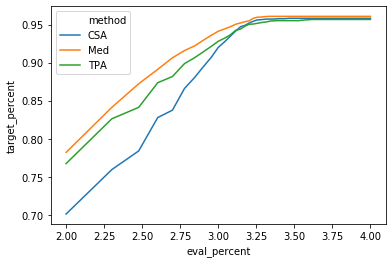

In [11]:
import seaborn as sns
ax = sns.lineplot(x = "eval_percent", y = "target_percent",  hue = "method", data = avgRes[avgRes["func"] == '13'])
#ax.set_xscale('log', basex=2)
#ax.set_yscale('log', basey=2)
ax

In [3]:
func_groups = { str(i) : "Unimodal functions" for i in range(1,3) }
func_groups.update({str(i) : "Simple Multimodal Functions" for i in range(4,11)})
func_groups.update({str(i) : "Hybrid Functions" for i in range(11,21)})
func_groups.update({str(i) : "Composition Functions" for i in range(21,31)})
#func_groups
func_groups_list = ["Unimodal functions (1 and 3)", "Simple Multimodal Functions (4-10)", "Hybrid Functions (11-20)", "Composition Functions (21-30)"]

In [4]:
avgRes = avgRes.assign(func_group = avgRes["func"].map(func_groups))

In [5]:
avgResFinal = avgRes.groupby(["dim","method","func_group","eval_percent"]).mean().reset_index()

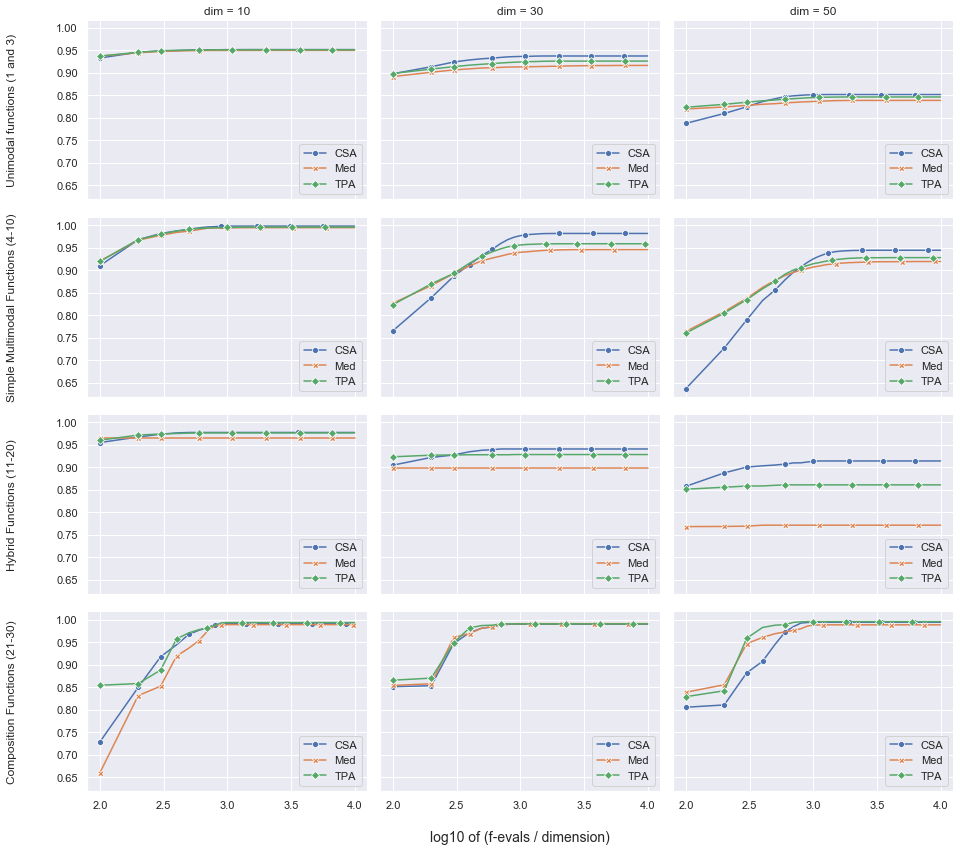

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
#sns.reset_orig()
g = sns.FacetGrid(avgResFinal, row = "func_group", col = "dim", hue = "method", 
                  #despine = True
                  #sharex = True, sharey = "col",
                  height=3, aspect=9/6, 
                  hue_kws={"marker":['o','X','D'], "markevery":[0.1,0.1,0.1]}) #markevery pokazuje najblizszy punkt co 0.1xBoundingBox osi
g.map(sns.lineplot, "eval_percent", "target_percent")
#plt.subplots_adjust(bottom=0.05, top=0.95)
#plt.legend(loc = "best")
axes = g.axes.flatten()
axes[0].set_title("dim = 10")
axes[1].set_title("dim = 30")
axes[2].set_title("dim = 50")
for ax in axes:
    ax.legend(loc = "lower right")
    ax.set_xlabel("")
    ax.set_ylabel("")
for ax in axes[3:]:
    ax.set_title("")
for idx, ax in enumerate(axes[0::3]):
    ax.set_ylabel(func_groups_list[idx] + '\n\n\n')
axes[10].set_xlabel("\nlog10 of (f-evals / dimension)")
axes[10].xaxis.label.set_fontsize(14)
plt.tight_layout()
plt.savefig("output3.pdf")

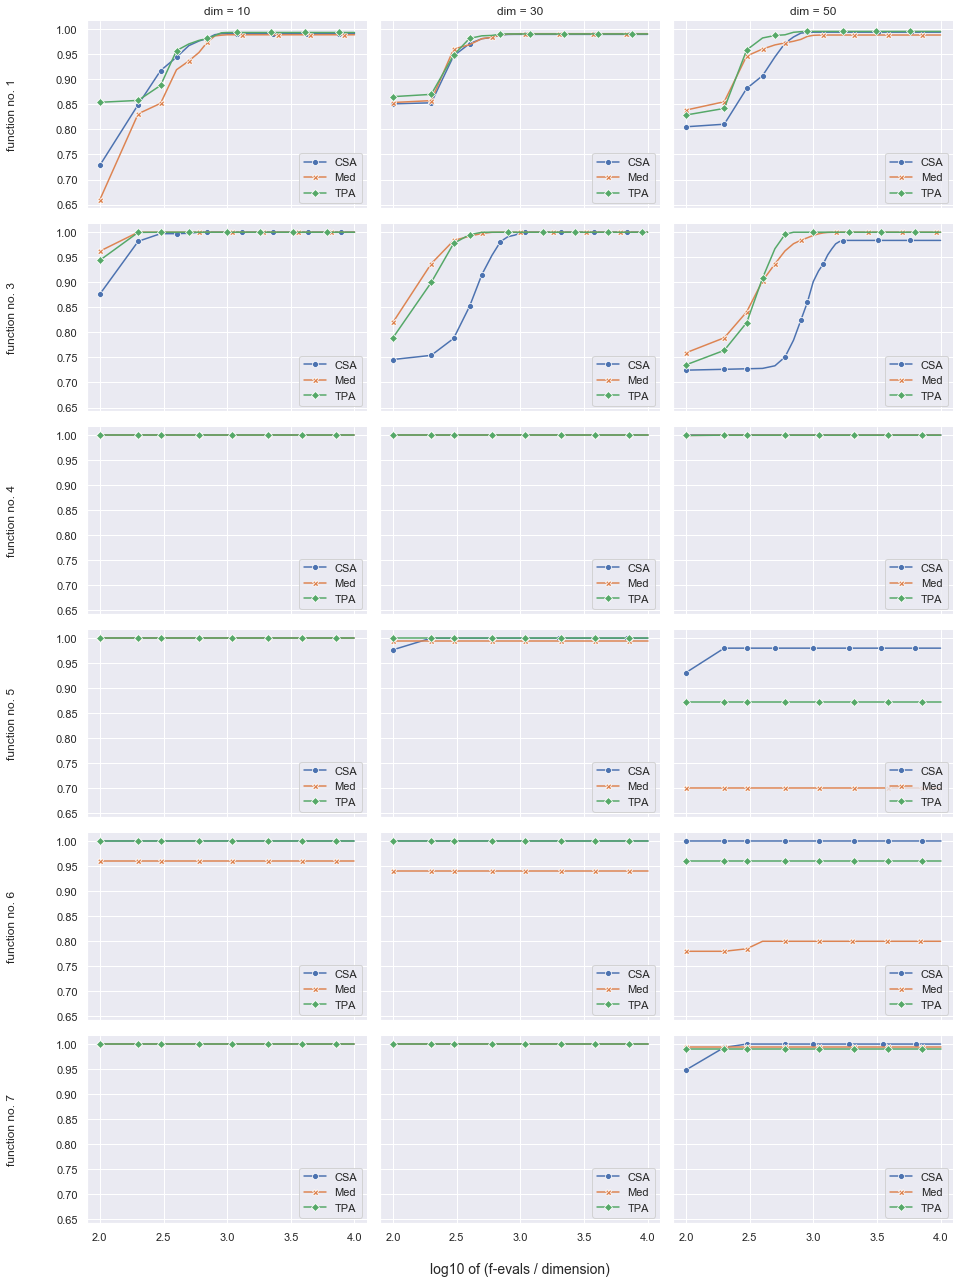

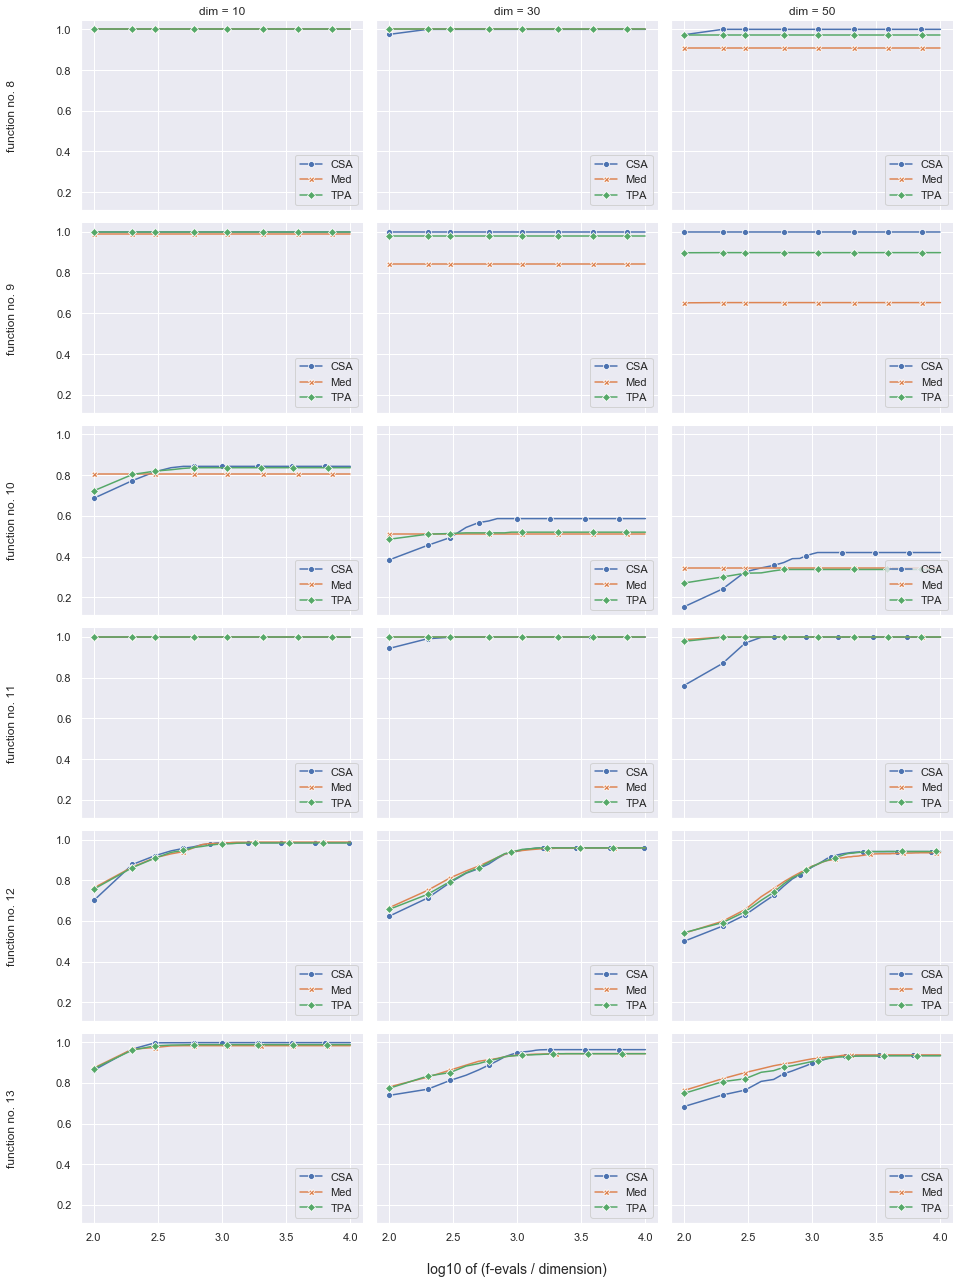

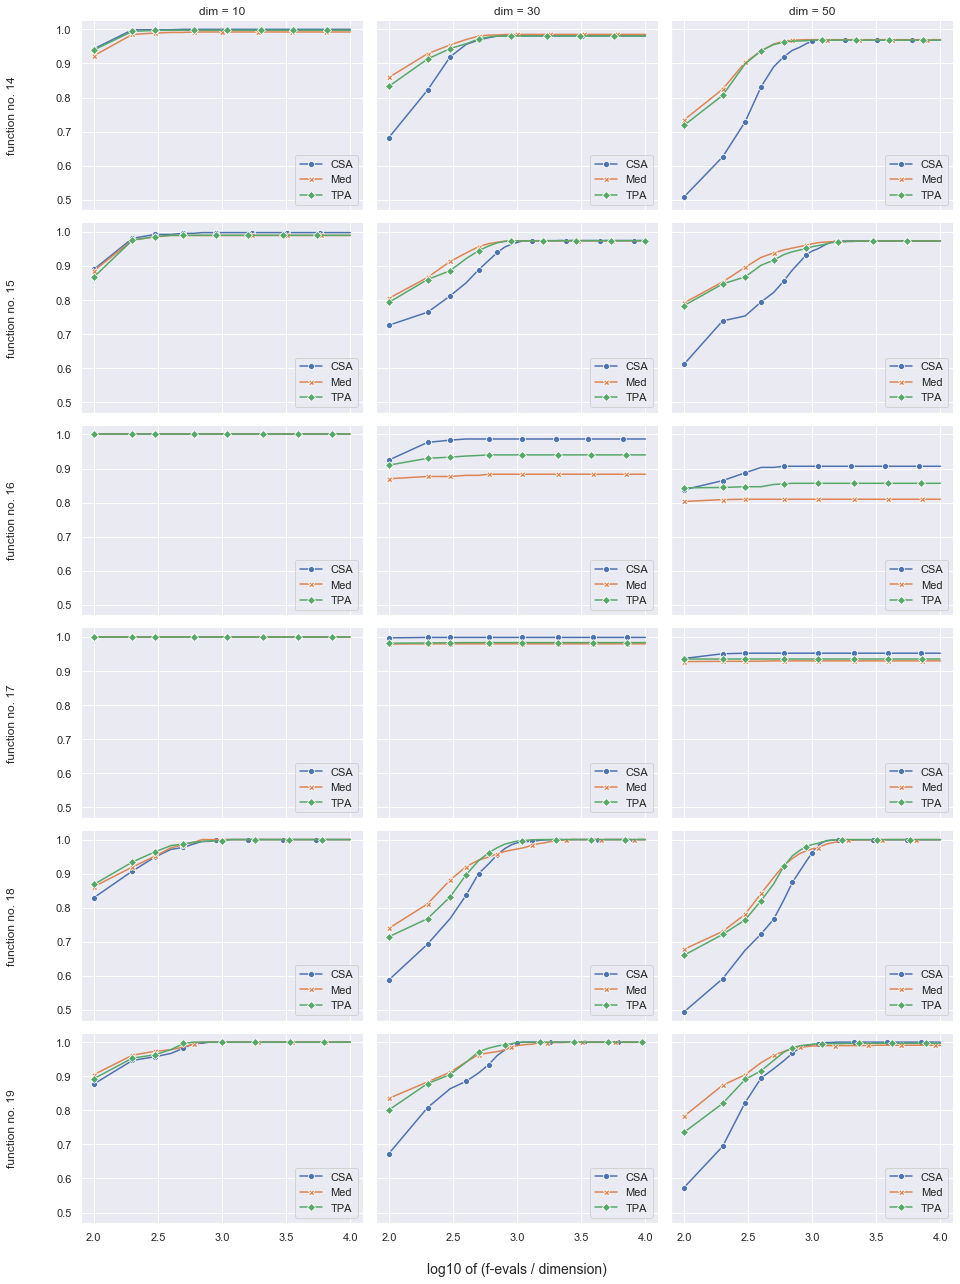

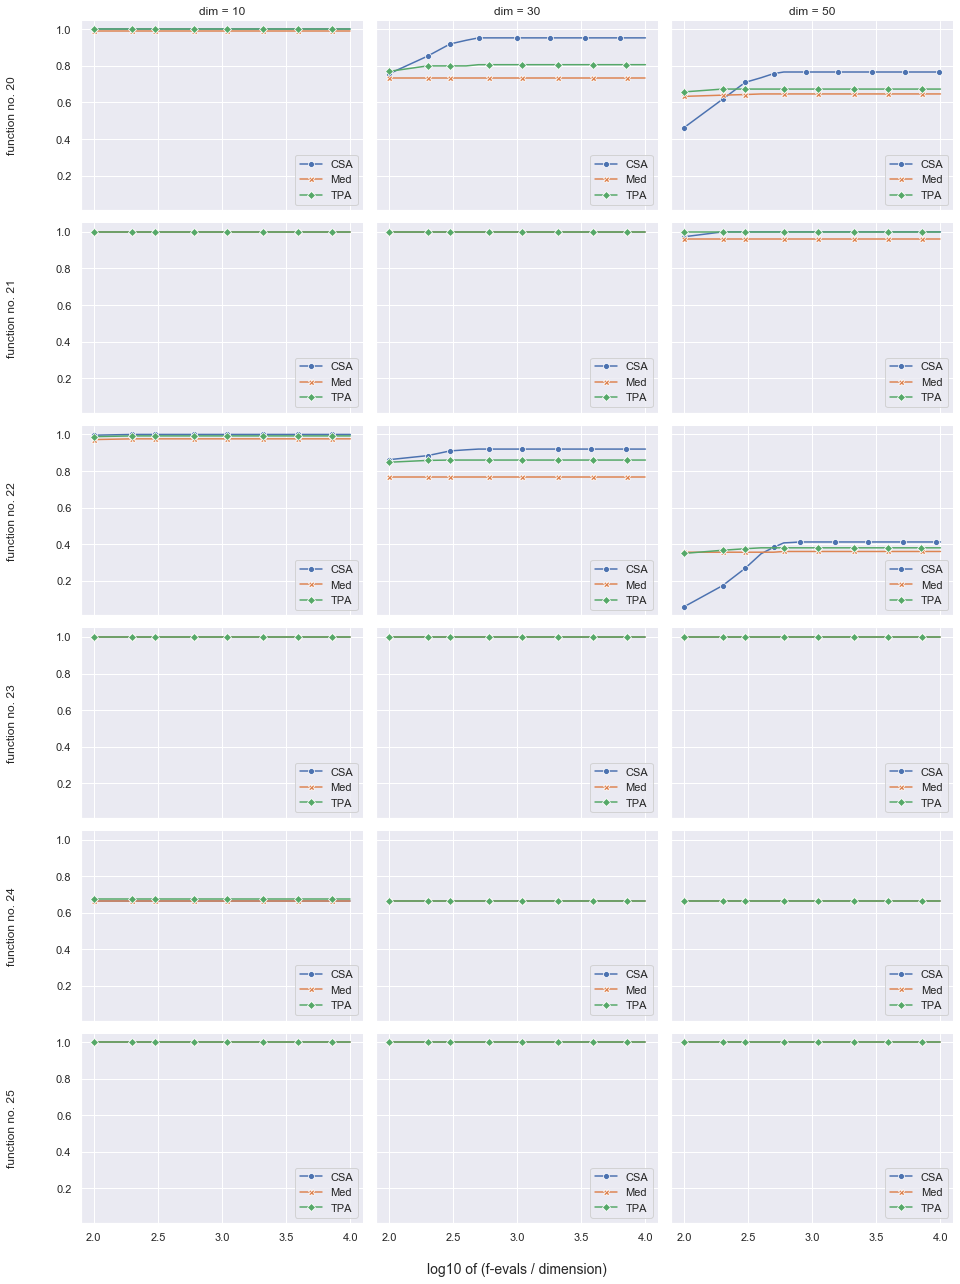

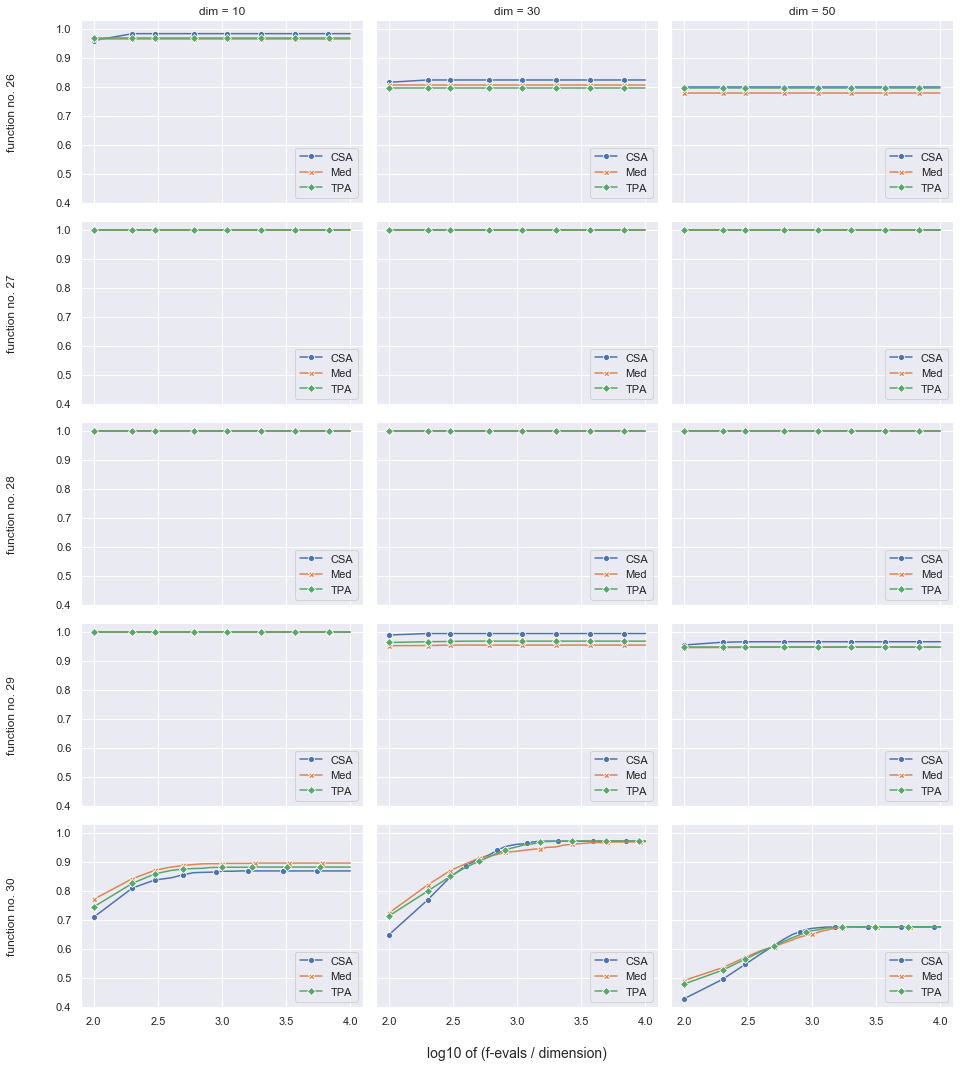

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

allbyFunc = pd.DataFrame(avgRes) #alredy grouped by method func dim eval_percent
allbyFunc["func"] = allbyFunc[["func"]].astype(int)

for a,b in [(1,7),(8,13), (14, 19), (20, 25), (26,31)]:
    sns.set()
    #sns.reset_orig()
    g = sns.FacetGrid(allbyFunc[(allbyFunc["func"] >= a) & (allbyFunc["func"] <= b)], row = "func", col = "dim", hue = "method", 
                      #despine = True
                      #sharex = True, sharey = "col",
                      height=3, aspect=9/6, 
                      hue_kws={"marker":['o','X','D'], "markevery":[0.1,0.1,0.1]}) #markevery pokazuje najblizszy punkt co 0.1xBoundingBox osi
    g.map(sns.lineplot, "eval_percent", "target_percent")
    #plt.subplots_adjust(bottom=0.05, top=0.95)
    #plt.legend(loc = "best")
    axes = g.axes.flatten()
    axes[0].set_title("dim = 10")
    axes[1].set_title("dim = 30")
    axes[2].set_title("dim = 50")
    for ax in axes:
        ax.legend(loc = "lower right")
        ax.set_xlabel("")
        ax.set_ylabel("")
    for ax in axes[3:]:
        ax.set_title("")

    idx_list = [x for x in range(a,b+1) if x not in [2]]
    for idx, ax in enumerate(axes[0::3]):
        ax.set_ylabel("function no. " + str(idx_list[idx]) + '\n\n\n')
    axes[-2].set_xlabel("\nlog10 of (f-evals / dimension)")
    axes[-2].xaxis.label.set_fontsize(14)
    plt.tight_layout()
    plt.savefig("allFunctions" + str(a) + "-" + str(b) + ".pdf")

In [16]:
res50 = pd.DataFrame(avgRes[avgRes["dim"] == 10]) #alredy grouped by method func dim eval_percent
res50["func"] = res50[["func"]].astype(int)

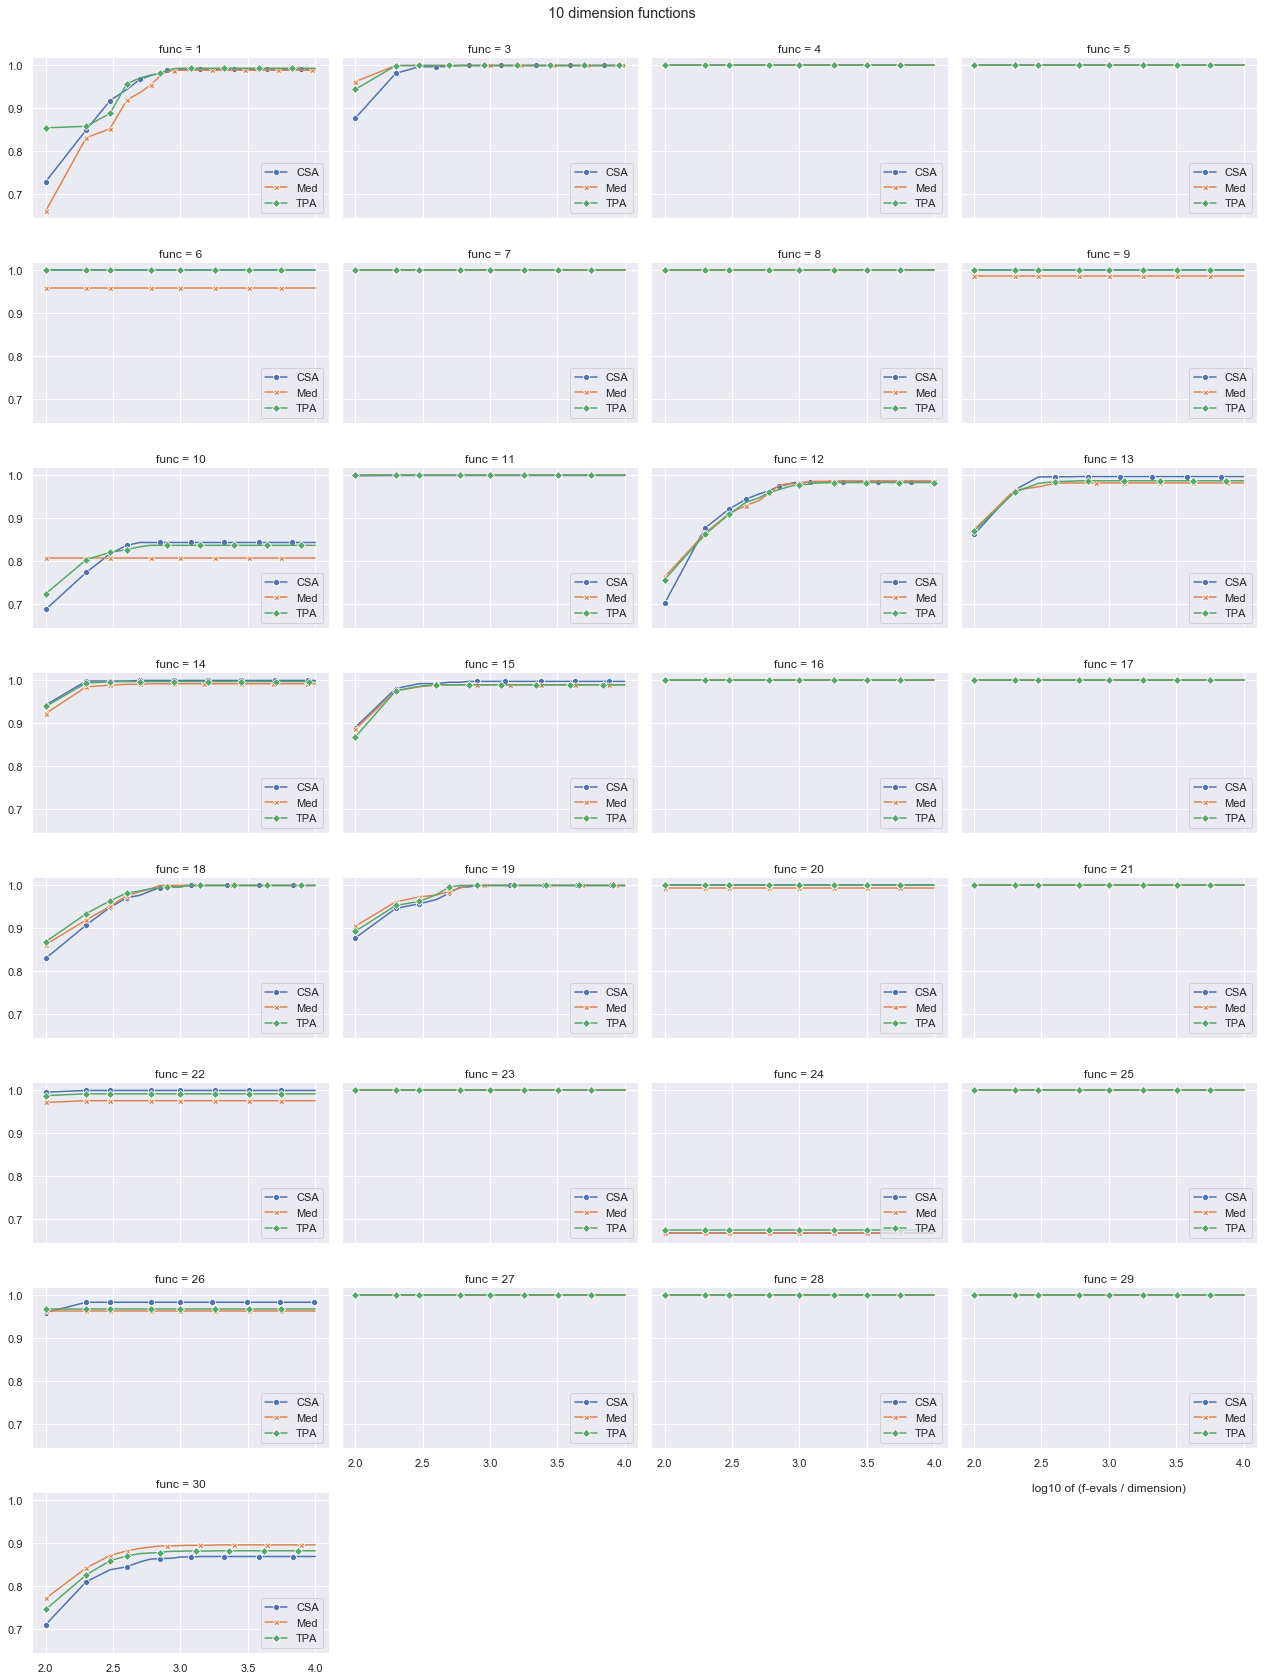

In [17]:
r = sns.FacetGrid(res50, col = "func", hue = "method",
                  col_wrap = 4,
                  #despine = True
                  #sharex = True, sharey = "col",
                  height=3, aspect=9/6, 
                  hue_kws={"marker":['o','X','D'], "markevery":[0.1,0.1,0.1]})
r.map(sns.lineplot, "eval_percent", "target_percent")
plt.subplots_adjust(top=0.95)
r.fig.suptitle("10 dimension functions")
axes = r.axes.flatten()
for ax in axes:
    ax.legend(loc = "lower right")
    ax.set_xlabel("")
    ax.set_ylabel("")
axes[-1].set_xlabel("\nlog10 of (f-evals / dimension)")
plt.savefig("10dimAllfunc.pdf")

In [168]:
test9 = resDF[resDF["func"] == '9']
test9 = test9.drop(columns = ['dim','max_val','min_val', 'eval_num', 'eval_percent'])
test9.groupby(["method"]).describe()['bestever']

,count,mean,std,min,25%,50%,75%,max
method,,,,,,,,
CSA,1610.0,12059.947546,25131.560962,900.0,901.178904,908.511184,4966.293523,111916.576139
Med,2539.0,10444.439280,20295.701212,900.0,2155.060043,4323.109706,6803.908000,111916.576139
TPA,2202.0,9085.155263,21196.363690,900.0,981.129387,1248.803551,2905.191041,111916.576139


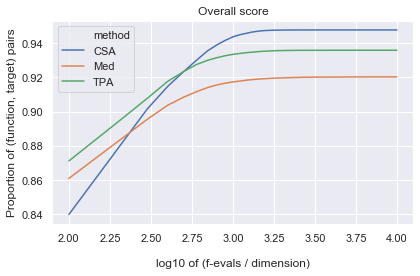

In [7]:
onePlotData = avgRes.groupby(["method","eval_percent"]).mean().reset_index()
onePlotData = onePlotData.drop(columns = ["dim"])
w = sns.lineplot(data = onePlotData, x = "eval_percent", y = "target_percent", hue = "method")
w.set_xlabel("\nlog10 of (f-evals / dimension)")
w.set_ylabel("Proportion of (function, target) pairs")
w.set_title("Overall score")
plt.tight_layout()
plt.savefig("overall.pdf")

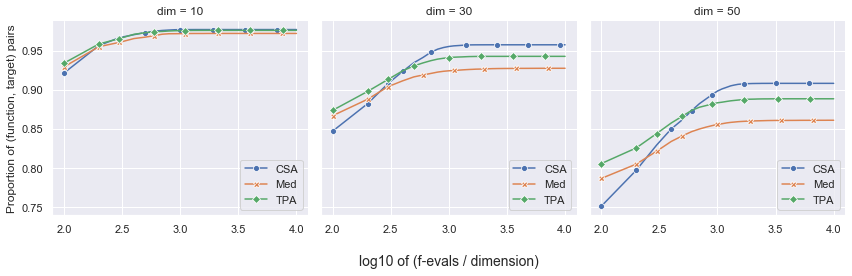

In [8]:
onePlotData = avgRes.groupby(["method","dim", "eval_percent"]).mean().reset_index()
sns.set()
#sns.reset_orig()
g = sns.FacetGrid(onePlotData, col = "dim", hue = "method", 
                  #despine = True
                  #sharex = True, sharey = "col",
                  height=4, aspect=1, 
                  hue_kws={"marker":['o','X','D'], "markevery":[0.1,0.1,0.1]}) #markevery pokazuje najblizszy punkt co 0.1xBoundingBox osi
g.map(sns.lineplot, "eval_percent", "target_percent")
#plt.subplots_adjust(bottom=0.05, top=0.95)
#plt.legend(loc = "best")
axes = g.axes.flatten()
axes[0].set_title("dim = 10")
axes[1].set_title("dim = 30")
axes[2].set_title("dim = 50")
for ax in axes:
    ax.legend(loc = "lower right")
    ax.set_xlabel("")
    ax.set_ylabel("")
axes[0].set_ylabel("Proportion of (function, target) pairs")
axes[1].set_xlabel("\nlog10 of (f-evals / dimension)")
axes[1].xaxis.label.set_fontsize(14)
plt.tight_layout()
plt.savefig("overallDim.pdf")